In [1]:
# =========================
# 1. Imports et setup
# =========================
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [2]:

# =========================
# 4. Dataset PyTorch
# =========================

TRAIN_FILE = "./ressources/npyDS/DataSetLasso/train.csv"
VAL_FILE   = "./ressources/npyDS/DataSetLasso/val.csv"
TEST_FILE  = "./ressources/npyDS/DataSetLasso/test.csv"
SUBMISSION_FILE = "./ressources/results/Trans_Lasso_1e5.csv"
MODEL_FILE = "./ressources/models/trans_model_lasso_1e5.joblib"

df_train = pd.read_csv(TRAIN_FILE)
df_val   = pd.read_csv(VAL_FILE)

X_train = df_train.drop(columns=["y"]).to_numpy(dtype="float32")
y_train = df_train["y"].to_numpy(dtype="float32")

X_val = df_val.drop(columns=["y"]).to_numpy(dtype="float32")
y_val = df_val["y"].to_numpy(dtype="float32")

In [3]:

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)



In [4]:
class TabTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, n_heads=4, n_layers=2, dropout=0.2):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers
        )

        self.regressor = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.embedding(x)   # (B, d_model)
        x = x.unsqueeze(1)      # (B, 1, d_model)
        x = self.encoder(x)     # (B, 1, d_model)
        x = x.squeeze(1)        # (B, d_model)
        return self.regressor(x).squeeze(1)

In [5]:
import torch
torch.backends.mkldnn.enabled = False
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

model = TabTransformer(
    input_dim=X_train.shape[1],
    dropout=0.2
).to(device)

In [6]:
# =========================
# 6. Entraînement & évaluation
# =========================
def train_model(model, train_loader, val_loader, epochs=200, lr=1e-4, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(Xb), yb)
            loss.backward()
            optimizer.step()

        val_loss = evaluate_model(model, val_loader, criterion)
        print(f"Epoch {epoch + 1}/{epochs} | Val loss: {val_loss:.4f}")
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_state = model.state_dict()
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    model.load_state_dict(best_state)




def evaluate_model(model, loader, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            losses.append(criterion(model(Xb), yb).item())
    return np.mean(losses)


# Entraînement
# model = TabTransformer(input_dim=1024).to(device)
# model = TabTransformer(input_dim=1024, dropout=0.2).to(device)
train_model(model, train_loader, val_loader, epochs=2000, lr=1e-5, patience=20)



Epoch 1/2000 | Val loss: 0.0158
Epoch 2/2000 | Val loss: 0.0130
Epoch 3/2000 | Val loss: 0.0128
Epoch 4/2000 | Val loss: 0.0120
Epoch 5/2000 | Val loss: 0.0126
Epoch 6/2000 | Val loss: 0.0118
Epoch 7/2000 | Val loss: 0.0111
Epoch 8/2000 | Val loss: 0.0112
Epoch 9/2000 | Val loss: 0.0114
Epoch 10/2000 | Val loss: 0.0105
Epoch 11/2000 | Val loss: 0.0100
Epoch 12/2000 | Val loss: 0.0095
Epoch 13/2000 | Val loss: 0.0087
Epoch 14/2000 | Val loss: 0.0080
Epoch 15/2000 | Val loss: 0.0078
Epoch 16/2000 | Val loss: 0.0081
Epoch 17/2000 | Val loss: 0.0074
Epoch 18/2000 | Val loss: 0.0072
Epoch 19/2000 | Val loss: 0.0070
Epoch 20/2000 | Val loss: 0.0067
Epoch 21/2000 | Val loss: 0.0070
Epoch 22/2000 | Val loss: 0.0066
Epoch 23/2000 | Val loss: 0.0064
Epoch 24/2000 | Val loss: 0.0063
Epoch 25/2000 | Val loss: 0.0064
Epoch 26/2000 | Val loss: 0.0061
Epoch 27/2000 | Val loss: 0.0062
Epoch 28/2000 | Val loss: 0.0060
Epoch 29/2000 | Val loss: 0.0060
Epoch 30/2000 | Val loss: 0.0057
Epoch 31/2000 | Val

RMSE : 0.0549 | MAE: 0.0379 | R²: 0.9296


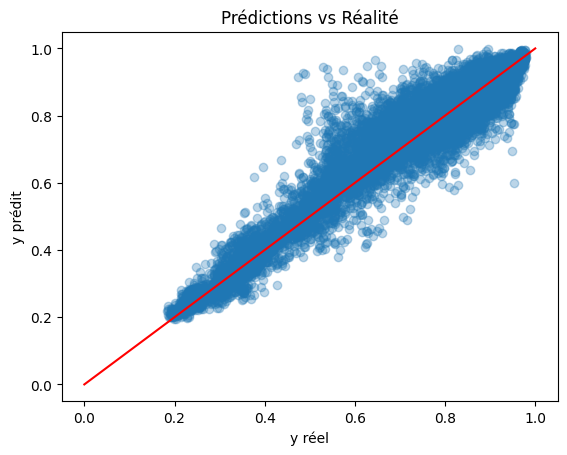

In [7]:

# =========================
# 7. Évaluation finale
# =========================
def predict(model, X):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(X_tensor).cpu().numpy()


y_val_pred = predict(model, X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"RMSE : {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([0, 1], [0, 1], color='r')
plt.xlabel("y réel")
plt.ylabel("y prédit")
plt.title("Prédictions vs Réalité")
plt.show()


In [8]:

# -------------------------
# Sauvegarde du modèle
# -------------------------
import joblib

joblib.dump(model, MODEL_FILE)

['./ressources/models/trans_model_lasso_1e5.joblib']

In [9]:
# =========================
# 8. Test et export (PREPROCESSED)
# =========================

# Test PCA (sans id)
df_test_pca = pd.read_csv(TEST_FILE)
X_test = df_test_pca.to_numpy(dtype="float32")

# IDs depuis le dataset brut
df_test_raw = pd.read_csv("./ressources/test.csv")
ids = df_test_raw["id"]

model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test).to(device)
    y_test_pred = model(X_test_tensor).cpu().numpy()

df_submission = pd.DataFrame({
    "id": ids,
    "wip": 0,
    "investissement": 0,
    "satisfaction": y_test_pred
})

df_submission.to_csv(
    SUBMISSION_FILE,
    index=False
)

print("✅ Fichier généré avec succès")

✅ Fichier généré avec succès
